# LSTM - Long Short Term Memory Networks + GloVe

En este notebook se va a utilizar una red LSTM para clasificar el texto de comentarios de Reddit, utilizando el modelo preentrenado de word embeddings GloVe.

In [1]:
import tensorflow as tf
print(tf.__version__)

2024-05-11 07:26:40.670915: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 07:26:40.717384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 07:26:40.717415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 07:26:40.718612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 07:26:40.725858: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import seaborn as sns

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)

# Cargar los datos y dividirlos en training y validation


In [3]:
df = pd.read_csv('./data/goemotions_clean.csv', sep=",")
df.head()

,text,emotion
0,Shhh dont give idea,anger
1,Thank much kind stranger I really need,gratitude
2,Ion know would better buy trim make hard dose,neutral
3,Im honestly surprised We fallen much farther,excitement
4,Jurisprudence fetishist get technicality,neutral


In [4]:
# Dividir el dataset en train y validation
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['emotion'], test_size=0.2, random_state=0)

# Preprocesamiento de los datos
Para poder utilizar los datos en la red neuronal, es necesario preprocesarlos. El texto debe ser convertido a números, ya que las redes neuronales no pueden trabajar con texto. Para ello, se utiliza la clase Tokenizer de Keras, que convierte el texto a secuencias de números. Además, se añade padding a las secuencias para que todas tengan la misma longitud.

In [5]:
def tokenization(tokenizer: Tokenizer, X_train: pd.Series, X_test: pd.Series) -> tuple[np.ndarray, np.ndarray, int, int]:
    # Fit tokenizer on train set
    tokenizer.fit_on_texts(X_train)

    # Convert text to sequences for both train and test sets
    train_sequences = tokenizer.texts_to_sequences(X_train)
    test_sequences = tokenizer.texts_to_sequences(X_test)

    # Get length of the longest sequence
    max_seq_len = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))

    # Get vocabulary size
    vocab_size = len(tokenizer.word_index) + 1  # +1 for zero padding
    
    # Applying padding to both train and test sets
    train_padded = pad_sequences(train_sequences, maxlen=max_seq_len, padding="post")
    test_padded = pad_sequences(test_sequences, maxlen=max_seq_len, padding="post")

    return train_padded, test_padded, max_seq_len, vocab_size, tokenizer

In [6]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, val_padded, max_seq_len, vocab_size, tokenizer = tokenization(tokenizer, X_train, X_val)

In [7]:
# Convertir output a números
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

# Modelo de la red neuronal LSTM

Cargamos inicialmente los embeddings pre-entrenadas de GloVe y creamos una matriz basada en los embeddings cargados y el vocabulario del modelo.

In [8]:
def load_glove_embeddings(path_to_glove_file: str) -> dict:
    """
    Loads GloVe embeddings.

    Args:
    -------
    path_to_glove_file: str
        Path to the GloVe embeddings file.

    Returns:
    -------
    embeddings_index: dict
        Dictionary where each key is a word and each value is the corresponding embedding.
    """
    embeddings_index = {}
    with open(path_to_glove_file, encoding="utf8") as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    return embeddings_index

def create_embedding_matrix(embeddings_index: dict, tokenizer: keras.preprocessing.text.Tokenizer, num_tokens: int, embedding_dim: int) -> tuple[np.ndarray, int, int]:
    """
    Creates an embedding matrix.

    Args:
    -------
    embeddings_index: dict
        Dictionary where each key is a word and each value is the corresponding embedding.
    tokenizer: keras.preprocessing.text.Tokenizer
        Tokenizer to use.
    num_tokens: int
        Number of tokens.
    embedding_dim: int
        Dimension of the embeddings.

    Returns:
    -------
    embedding_matrix: np.array
        Embedding matrix.
    hits: int
        Number of words in the vocabulary that are also in the embeddings.
    misses: int
        Number of words in the vocabulary that are not in the embeddings.
    """
    # Initialize hits and misses to 0
    # i) hits: number of words in the vocabulary that are also in the embeddings
    # ii) misses: number of words in the vocabulary that are not in the embeddings
    hits = 0
    misses = 0
    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    return embedding_matrix, hits, misses

In [9]:
num_tokens = vocab_size + 1
# Define embedding dimension for GloVe (this is needed in order to load the corresponding embeddings)
embedding_dim = 100

path_to_glove_file = 'data/gloveTwitter/glove.twitter.27B.100d.txt'

In [10]:
embeddings_index = load_glove_embeddings(path_to_glove_file)
print(f"Found {len(embeddings_index)} word vectors.")

Found 148990 word vectors.


In [11]:
embedding_matrix, hits, misses = create_embedding_matrix(embeddings_index, tokenizer, num_tokens, embedding_dim)
print(f"Converted {hits} words ({misses} misses)")

Converted 16416 words (11130 misses)


## Definición y entrenamiento del modelo:

Se construye entonces el modelo de red neuronal para clasificar secuencias de texto en 23 categorías. Se detallan las siguientes partes del modelo:

+ Capa de Embedding: Convierte índices de palabras en vectores densos.
+ Capa LSTM Bidireccional: Procesa la secuencia en ambas direcciones para capturar relaciones de largo plazo.
+ Capa de Flatten: Transforma la salida en un vector unidimensional.
+ Capa de Dropout: Aplica regularización para evitar el sobreajuste.
+ Capas Densas: Procesan el vector unidimensional con activaciones ReLU y softmax.
+ Compilación del Modelo: Se define el optimizador, la función de pérdida y la métrica de evaluación, con una regularización L2 para evitar el sobreajuste.

In [12]:
model = Sequential()

# Embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    # input_length=max_seq_len,
    trainable=False,
)

model.add(embedding_layer)

# Add Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=128, recurrent_dropout=0.5, dropout=0.5)))

# Flatten and Dense Layers
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))

# Output layer
model.add(Dense(23, activation="softmax"))

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2024-05-11 07:26:48.629183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 07:26:48.671996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-11 07:26:48.672225: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Entrenamiento:

In [13]:
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [14]:
model_path = os.path.join(models_dir, "lstm_glove_model.keras")

Se configuran también las siguientes componentes adicionales del modelo:

+ EarlyStopping: callback que detiene el entrenamiento del modelo si no observa una mejora en la métrica de pérdida en el conjunto de validación durante un número especificado de épocas consecutivas.

+ ModelCheckpoint: callback que guarda el modelo como un archivo en el disco después de cada época si se ha observado una mejora en la métrica de pérdida en el conjunto de validación.

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [16]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(val_padded, np.array(y_val)),
    callbacks = [es, mc]
)

Epoch 1/30


2024-05-11 07:26:55.106664: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f58dc8257a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-11 07:26:55.106699: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-05-11 07:26:55.112940: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-11 07:26:55.129788: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1715412415.227797   12882 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1346/1346 [==============================] - ETA: 0s - loss: 2.5324 - accuracy: 0.2964
Epoch 1: val_loss improved from inf to 2.36209, saving model to ./models/lstm_glove_model.keras
1346/1346 [==============================] - 126s 89ms/step - loss: 2.5324 - accuracy: 0.2964 - val_loss: 2.3621 - val_accuracy: 0.3185
Epoch 2/30
1346/1346 [==============================] - ETA: 0s - loss: 2.3843 - accuracy: 0.3172
Epoch 2: val_loss improved from 2.36209 to 2.30112, saving model to ./models/lstm_glove_model.keras
1346/1346 [==============================] - 119s 88ms/step - loss: 2.3843 - accuracy: 0.3172 - val_loss: 2.3011 - val_accuracy: 0.3314
Epoch 3/30
1346/1346 [==============================] - ETA: 0s - loss: 2.3314 - accuracy: 0.3250
Epoch 3: val_loss improved from 2.30112 to 2.27792, saving model to ./models/lstm_glove_model.keras
1346/1346 [==============================] - 118s 88ms/step - loss: 2.3314 - accuracy: 0.3250 - val_loss: 2.2779 - val_accuracy: 0.3355
Epoch 4/30
13

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2754800   
                                                                 
 bidirectional (Bidirection  (None, 256)               234496    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 23)                1495      
                                                        

In [18]:
def plot_metric_curves(epochs, train_curve, val_curve, train_color, val_color, metric, epochs_interval: int = 1):
    # Set graphics format as svg
    set_matplotlib_formats('svg')
    # Add grid
    sns.set_style("whitegrid")
    # Set figure size
    plt.figure(figsize=(12,8), dpi=200)
    # Plot curves
    plt.plot(epochs, train_curve, color=train_color, linewidth=2, label=f'Training {metric.lower()}')
    plt.plot(epochs, val_curve, color=val_color, linewidth=2, label=f'Validation {metric.lower()}')
    # Set title and labels
    plt.title(f'Training and validation {metric.lower()}', fontsize=20)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel(metric.capitalize(), fontsize=15)
    # Show epoch values in x-axis in the specified interval
    plt.xticks(epochs[::epochs_interval])
    # Set max x-axis as the last epoch + 1
    plt.xlim(0, epochs[-1] + 1)
    # Remove top and right spines
    sns.despine(left=True, bottom=True)
    # Put the legend outside of the plot
    plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    plt.show()
    return

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

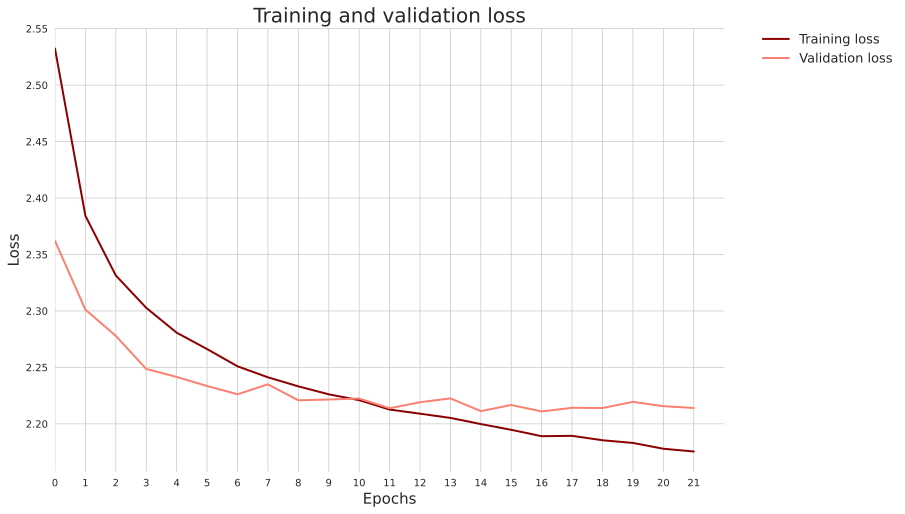

In [20]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkred", "salmon", "Loss", 1)

Tal y como se observa en la gráfica anterior, tanto la pérdida de entrenamiento como la de validación disminuyen constantemente, lo cual es bueno ya que indica que el modelo está aprendiendo y mejorando en la tarea de predecir los datos de entrenamiento. 

Aun así, es importante remarcar que la pérdida del conjunto de validación parece estabilizarse a partir de un determinado momento, pero que la diferencia con respecto al de entrenamiento no es lo suficientemente grande como para considerar overfit.

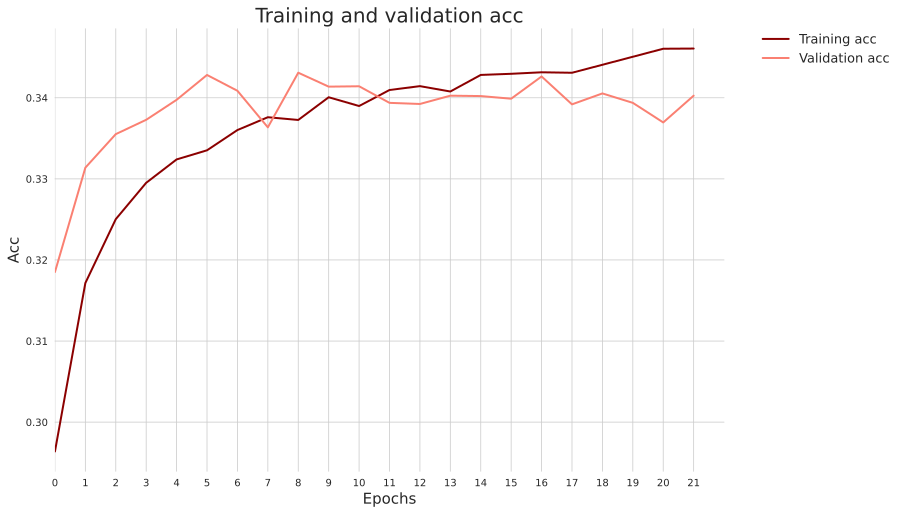

In [21]:
# Plot loss curves
plot_metric_curves(epochs, acc, val_acc, "darkred", "salmon", "acc", 1)

Esta gráfica muestra que la precisión de entrenamiento y de validación mejora de manera constante (aunque algo fluctuante), lo cual es lo que se espera de un modelo que está aprendiendo de los datos. 

Al igual que con la gráfica de pérdida, la diferencia entre el valor de entrenamiento y validación no es tan grande como para considerar que el modelo está sobreajustado. 

# Predicciones

In [22]:
# Predecir las emociones en el conjunto de validación
y_pred_probs = model.predict(val_padded)

# Obtener las etiquetas originales de las emociones
y_val_labels = label_encoder.inverse_transform(y_val)
emotion_labels = label_encoder.classes_

673/673 [==============================] - 7s 10ms/step


In [23]:
emotion_to_emoji = {
    'admiration': '🤩',
    'amusement': '😄',
    'anger': '😡',
    'annoyance': '😑',
    'approval': '👍',
    'caring': '🥰',
    'confusion': '😕',
    'curiosity': '🤔',
    'desire': '😏',
    'disappointment': '😞',
    'disapproval': '👎',
    'disgust': '🤢',
    'embarrassment': '😳',
    'excitement': '😃',
    'fear': '😨',
    'gratitude': '🙏',
    'joy': '😀',
    'love': '❤️',
    'neutral': '😐',
    'optimism': '😊',
    'realization': '😲',
    'sadness': '😢',
    'surprise': '😮'
}

In [24]:
# Dataframe con texto, emoción real y top 3 de emociones predichas con sus probabilidades
df_results = pd.DataFrame(columns=['text', 'top1', 'top2', 'top3'])
df_results['text'] = X_val

# Obtener las etiquetas de las emociones predichas
top1_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -1]]
top2_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -2]]
top3_labels = [emotion_labels[i] for i in y_pred_probs.argsort()[:, -3]]

# Mapear las emociones a emojis
top1_labels = [emotion_to_emoji[label] for label in top1_labels]
top2_labels = [emotion_to_emoji[label] for label in top2_labels]
top3_labels = [emotion_to_emoji[label] for label in top3_labels]

# Obtener las probabilidades de las emociones predichas
top1_probs = y_pred_probs.max(axis=1) * 100  # Multiplicar por 100 para obtener el porcentaje
top2_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -2]] * 100
top3_probs = y_pred_probs[np.arange(len(y_val)), y_pred_probs.argsort()[:, -3]] * 100

# Asignar valores al DataFrame
df_results['top1'] = [f'{label} {prob:.0f}%' for label, prob in zip(top1_labels, top1_probs)]
df_results['top2'] = [f'{label} {prob:.0f}%' for label, prob in zip(top2_labels, top2_probs)]
df_results['top3'] = [f'{label} {prob:.0f}%' for label, prob in zip(top3_labels, top3_probs)]

# Resetear el índice
df_results.reset_index(drop=True, inplace=True)

df_results.head()


,text,top1,top2,top3
0,Maybe could put context wa responding someone ...,😐 37%,😕 17%,👎 11%
1,NAME like picking choosing life work fact work,😐 44%,👍 16%,🤩 5%
2,How people eat paper plate theyre bbq,😐 34%,🤔 28%,😕 19%
3,Thank voice reason people keep screaming Vatic...,🙏 95%,😐 1%,😑 1%
4,Gotta love trailing minute,❤️ 54%,😐 12%,🤩 12%
